In [20]:
import data_functions as dat
import importlib
import itertools
import math
import matplotlib.pyplot as plt
from metric_functions import *
import multiprocessing as mp
import numpy as np
import os, os.path
import pandas as pd
import pyDOE2 as pyd
import scipy.optimize as sco
import setup_analysis as sa
import time
import ri_water_model as rm
importlib.reload(dat)
importlib.reload(sa)


<module 'setup_analysis' from '/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2023/crdm_project/python/setup_analysis.py'>

In [23]:
importlib.reload(dat)
importlib.reload(sa)

<module 'setup_analysis' from '/Users/jsyme/Documents/Projects/git_jbus/dmdu_scalable_computing_2023/crdm_project/python/setup_analysis.py'>

###  First, let's read in key data sets and print off some information for our analysis.

In [24]:
# read in input data
df_model_data = pd.read_csv(sa.fp_csv_baseline_trajectory_model_input_data)
df_climate_deltas_annual = pd.read_csv(sa.fp_csv_climate_deltas_annual)

# show a record of info
print(f"Analysis Information from setup_analysis.py\n\n\tanalysis_name:\t{sa.analysis_name}\n\tn_lhs:\t{sa.n_lhs}")


Analysis Information from setup_analysis.py

	analysis_name:	crdm_project_20230729T071612494370_100fut
	n_lhs:	100


###  Next, let's load the strategy table

In [25]:
# get the strategies and attribute table from the excel file
df_attr_strategy, df_strategies = dat.get_strategy_table(sa.fp_xlsx_strategy_inputs, field_strategy_id = sa.field_key_strategy)


###  Add the LHS samples

###  Apply the climate deltas

In [6]:

##  Climate Deltas

t0 = time.time()
dict_climate_factor_delta_field_map =  {
    "flow_m3s": "flow_m3s",
    "precipitation_mm": "precipitation_mm"
}
df_climate_deltas_by_future = dat.get_climate_factor_deltas(
    df_model_data,
    df_lhs,
    dict_climate_factor_delta_field_map,
    sa.range_delta_base, 
    sa.range_delta_fut, 
    max(sa.model_historical_years),
    field_future_id = sa.field_key_future
)
t1 = time.time()
t_del = np.round(t1 - t0, 2)
print(f"Time to generate {sa.n_lhs} climate deltas: {t_del} seconds")



Time to generate 1000 climate deltas: 20.97 seconds


###  Let's add the other uncertainty deltas (treated differently)

In [7]:
# get time period information
t0 = max(df_model_data[df_model_data["year"] == min(sa.model_projection_years) - 1]["time_period"])
t1 = max(df_model_data["time_period"])

# run the function
df_other_deltas_by_future = dat.get_linear_delta_trajectories_by_future(
    df_model_data,
    df_lhs[[x for x in df_lhs.columns if x not in dict_climate_factor_delta_field_map.keys()]],
    t0,
    t1,
    field_future_id = sa.field_key_future
)
# merge back in some data
df_other_deltas_by_future = pd.merge(df_other_deltas_by_future, df_model_data[["time_period", "year", "month"]])



###  Build a unified futures database

In [8]:
df_futures = pd.merge(df_climate_deltas_by_future, df_other_deltas_by_future)
# some column sorting
fields_ind = ["future_id", "time_period", "year", "month"]
fields_dat = sorted([x for x in df_futures.columns if x not in fields_ind])
df_futures = df_futures[fields_ind + fields_dat]

###  Create a primary key, which we can use for an experimental design

In [9]:
def build_primary_attribute(
    df_fut: pd.DataFrame,
    df_strat: pd.DataFrame,
    field_key_future: str = "future_id",
    field_key_primary: str = "primary_id",
    field_key_strategy: str = "strategy_id"
) -> pd.DataFrame:
    
    # create a primary key
    fields_index = [field_key_strategy, field_key_future]
    field_primary_key = field_key_primary
    df_attribute_primary = pd.DataFrame(
        list(itertools.product(
            list(df_strat[field_key_strategy]), 
            list(df_fut[field_key_future])
        )), 
        columns = fields_index
    )
    df_attribute_primary[field_key_primary] = range(len(df_attribute_primary))
    df_attribute_primary = df_attribute_primary[[field_key_primary] + fields_index]
    
    return df_attribute_primary

df_attribute_primary = build_primary_attribute(
    df_lhs, 
    df_attr_strategy, 
    sa.field_key_future, 
    sa.field_key_primary, 
    sa.field_key_strategy
)



###  Run the model under default conditions

In [10]:
df_out = rm.ri_water_resources_model(df_model_data)

RI model done in 1.49 seconds.


###  Define a function to run the model for a single scenario

In [11]:
# function here
def get_model_data_from_primary_key(
    id_primary: int,
    df_attribute_primary: pd.DataFrame,
    df_futures: pd.DataFrame,
    df_strategies: pd.DataFrame,
    field_primary_key: str = "primary_id",
    field_future: str = "future_id", 
    field_strategy: str = "strategy_id"
):
    row_scenario = df_attribute_primary[df_attribute_primary[field_primary_key] == id_primary]
    # get ids
    id_future = int(row_scenario[field_future])
    id_primary = int(row_scenario[field_primary_key])
    id_strategy = int(row_scenario[field_strategy])

    # get input data
    df_future = df_futures[df_futures[field_future] == id_future].copy()
    df_future.drop([field_future], axis = 1, inplace = True)
    df_strategy = df_strategies[df_strategies[field_strategy] == id_strategy].copy()
    df_strategy.drop([field_strategy], axis = 1, inplace = True)
    df_input_data = pd.merge(df_future, df_strategy)
    
    return df_input_data


def run_model_by_primary_key(
    id_primary: int,
    df_attribute_primary: pd.DataFrame,
    df_futures: pd.DataFrame,
    df_strategies: pd.DataFrame,
    field_primary_key: str = "primary_id",
    field_future: str = "future_id", 
    field_strategy: str = "strategy_id"
):

    df_input_data = get_model_data_from_primary_key(
        id_primary,
        df_attribute_primary,
        df_futures,
        df_strategies,
        field_primary_key,
        field_future, 
        field_strategy
    )
    # model output
    df_out = rm.ri_water_resources_model(df_input_data)
    fields_ord = list(df_out.columns)
    df_out[field_primary_key] = id_primary
    df_out = df_out[[field_primary_key] + fields_ord]

    return df_out



###  Try running the model for a selected primary_id

In [12]:
id_primary = 10
df_run = run_model_by_primary_key(
    id_primary,
    df_attribute_primary,
    df_futures,
    df_strategies
)

RI model done in 1.43 seconds.


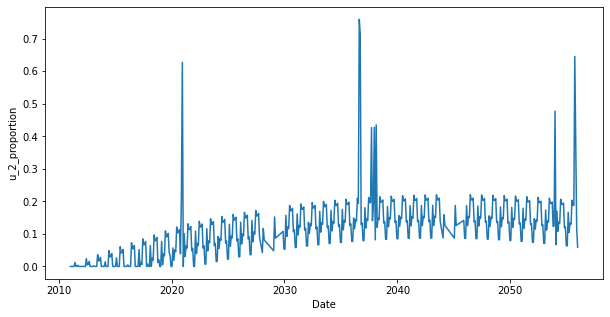

In [13]:
# 474
n = len(df_run)
flds_explore = [x for x in df_run.columns if (x not in ["year", "month"])]
flds_explore = ["u_2_proportion"]
for i in flds_explore:
    x = np.array(df_run["year"]) + (np.array(df_run["month"]) - 0.5)/12
    y = np.array(df_run[i].iloc[0:n])
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.set_xlabel("Date")
    ax.set_ylabel(str(i))
    ax.plot(x, y)
    plt.show()
    

###  Let's select some scenarios to run

In [26]:
all_primaries = list(df_attribute_primary[
    #df_attribute_primary["strategy_id"].isin([0, 1])&
    df_attribute_primary["future_id"].isin(list(range(200)))
]["primary_id"])


In [53]:
###########################
#    SERIAL 'FOR' LOOP    #
###########################

# initialize output values
vec_out = []

# set timer baseline
t0_serial = time.time()

df_out = []
# simple loop over
for id_primary in enumerate(all_primaries):
    
    ind, id_primary = id_primary
    
    ##  raw model output
    df_cur = run_model_by_primary_key(
        id_primary,
        df_attribute_primary,
        df_futures,
        df_strategies
    )

    
    ########################################################
    #    INSERT RELEVANT POST-PROCESSING FUNCTIONS HERE    #
    ########################################################

    df_metric_1 = get_mean_reservoir(
        df_cur,
        sa.field_key_primary,
        "year",
        10
    )
    
    df_metric_2 = get_mean_groundwater(
        df_ret, 
        sa.field_key_primary, 
        "year", 
        10
    )
    
    df_year_unacceptable, df_metric_3 = get_unacceptable_unmet_demand(
        df_cur,
        field_key_primary = sa.field_key_primary,
        field_measure = "u_2_proportion",
        field_metric_exceed = "exceed_threshes",
        field_metric_prop = "proportion_unacceptable_unmet_demand",
        field_month = "month",
        field_year = "year",
        thresh_count = 6,
        thresh_demand = 0.2
    )
    
    df_metrics_summary = pd.merge(df_metric_1, df_metric_2)
    df_metrics_summary = pd.merge(df_metrics_summary, df_metric_3)
    
    if len(df_out) == 0:
        df_out = [df_metrics_summary for x in all_primaries]
    else:
        df_out[ind] = df_metrics_summary[df_out[0].columns]
    
df_out = pd.concat(df_out, axis = 0).reset_index(drop = True)

t1_serial = time.time()
t_elapse_serial = t1_serial - t0_serial

print("Serial run complete in %s seconds."%t_elapse_serial)



RI model done in 1.54 seconds.
RI model done in 1.57 seconds.
RI model done in 1.47 seconds.
RI model done in 1.45 seconds.
RI model done in 1.54 seconds.
RI model done in 1.46 seconds.
RI model done in 1.41 seconds.
RI model done in 1.48 seconds.
RI model done in 1.28 seconds.
RI model done in 1.25 seconds.
RI model done in 1.24 seconds.
RI model done in 1.25 seconds.
RI model done in 1.24 seconds.
RI model done in 1.23 seconds.
RI model done in 1.25 seconds.
RI model done in 1.24 seconds.
RI model done in 1.27 seconds.
RI model done in 1.27 seconds.
RI model done in 1.37 seconds.
RI model done in 1.33 seconds.
RI model done in 1.36 seconds.
RI model done in 1.21 seconds.
RI model done in 1.2 seconds.
RI model done in 1.24 seconds.
RI model done in 1.25 seconds.
RI model done in 1.21 seconds.
RI model done in 1.21 seconds.
RI model done in 1.23 seconds.
RI model done in 1.2 seconds.
RI model done in 1.2 seconds.
RI model done in 1.19 seconds.
RI model done in 1.21 seconds.
RI model do

In [60]:
df_out_serial = pd.merge(df_attribute_primary, df_out)
df_out_serial = pd.merge(df_lhs, df_out_serial)
df_out_serial.head()

,future_id,area_ag_km2,demand_agricultural_m3km2,demand_municipal_m3p,flow_m3s,population,precipitation_mm,primary_id,strategy_id,mean_reservoir_storage_last_ten_years_m3,proportion_unacceptable_unmet_demand
0,0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0,0,1.278909e+08,0.377778
1,0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1001,1,1.308107e+08,0.000000
2,1,1.211033,0.995939,1.040430,-0.038626,0.815380,0.365864,1,0,1.596507e+08,0.000000
3,1,1.211033,0.995939,1.040430,-0.038626,0.815380,0.365864,1002,1,1.943025e+08,0.000000
4,2,1.351868,1.087951,1.053956,-0.328492,0.968407,0.249360,2,0,5.941367e+07,0.400000


###  Use Pool.apply_async() to get model runs in parallel

In [27]:
###############################
#    ASYNCHRONOUS PARALLEL    #
###############################

t0_par_async = time.time()

#
# SOLUTION TO GET APPLY_ASYNC TO WORK WITH JUPYTER LAB: FUNCTION HAS TO BE PLACED IN MODULE AND IMPORTED: https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3
# https://towardsdatascience.com/asynchronous-parallel-programming-in-python-with-multiprocessing-a3fc882b4023
#


# initialize output vector/array (pre-allocate memory)
vec_df_out_ri = []

def get_result(result):
    
    global vec_df_out_ri
    vec_df_out_ri.append(result)
   
    
# check to ensure current module is "__main__"; this is necessary in scripts that use multiprocessing. Without it, the processing framework will run the entirety of the original script in parallel
if __name__ == "__main__":

    # start the MP pool for asynchronous parallelization
    pool = mp.Pool(int(mp.cpu_count()/2))

    # apply the function; note: if the function only takes one argument (e.g., f(x)), make sure the args is args = (x, ) - that extra comma is important
    for id_primary in all_primaries:
        # function here
        
        df_input_data = get_model_data_from_primary_key(
            id_primary,
            df_attribute_primary,
            df_futures,
            df_strategies,
            sa.field_key_primary,
            sa.field_key_future, 
            sa.field_key_strategy
        )


        pool.apply_async(
            # target function
            rm.ri_water_resources_model,
            # function arguments 
            args = (
                df_input_data,
                rm.md_dict_initial_states, 
                rm.md_dict_parameters, 
                rm.md_dict_default_levers,
                id_primary
            ),
            callback = get_result
        )

     
    pool.close()
    pool.join()
    t1_par_async = time.time()

    # 
    #t_elapse_par_async = t1_par_async - t0_par_async

# print the reduction in time
#print("Asynchronous parallelization across %s cores reduced computational time by %s%s."%(mp.cpu_count(), round(100*(1 - t_elapse_par_async/t_elapse_serial), 2), "%"))



In [28]:
## use to collect and clean results after running in parallel
def get_metrics_from_node_return(result):
    
    id_primary, df_ret = result
    
    df_ret[sa.field_key_primary] = id_primary
    
    df_metric_1 = get_mean_reservoir(
        df_ret, 
        sa.field_key_primary, 
        "year", 
        10
    )
    
    df_metric_2 = get_mean_groundwater(
        df_ret, 
        sa.field_key_primary, 
        "year", 
        10
    )
    
    df_year_unacceptable, df_metric_3 = get_unacceptable_unmet_demand(
        df_ret,
        field_key_primary = sa.field_key_primary,
        field_measure = "u_2_proportion",
        field_metric_exceed = "exceed_threshes",
        field_metric_prop = "proportion_unacceptable_unmet_demand",
        field_month = "month",
        field_year = "year",
        thresh_count = 6,
        thresh_demand = 0.2
    )
    
    df_metrics_summary = pd.merge(df_metric_1, df_metric_2)
    #fields_ord = list(df_metrics_summary.columns)
    #df_metrics_summary = df_metrics_summary[[field_key_primary] + fields_ord]
    
    return df_metrics_summary


vec_df_metrics = []

for i in range(len(vec_df_out_ri)):
    
    # write out the results for the primary id
    if False:
        vec_df_out_ri[i][1].to_csv(
            os.path.join(sa.dir_out, f"model_result_pid_{vec_df_out_ri[i][0]}.csv"), index = None, encoding = "UTF-8"
        )
    df_cur = get_metrics_from_node_return(vec_df_out_ri[i])
    
    if len(vec_df_metrics) == 0:
        vec_df_metrics = [df_cur for x in vec_df_out_ri]
    else:
        vec_df_metrics[i] = df_cur[vec_df_metrics[0].columns]
vec_df_metrics = pd.concat(vec_df_metrics, axis = 0).reset_index(drop = True)


In [29]:
df_out_parallel = pd.merge(df_attribute_primary, vec_df_metrics)
df_out_parallel = pd.merge(df_lhs, df_out_parallel)

In [18]:
df_out_parallel#[["strategy_id", "future_id", "proportion_unacceptable_unmet_demand"]]

,future_id,area_ag_km2,demand_agricultural_m3km2,demand_municipal_m3p,flow_m3s,population,precipitation_mm,primary_id,strategy_id,mean_reservoir_storage_last_ten_years_m3,proportion_unacceptable_unmet_demand
0,0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0,0,1.278909e+08,0.377778
1,0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1001,1,1.308107e+08,0.000000
2,0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2002,2,2.095852e+08,0.000000
3,0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3003,3,1.358230e+08,0.377778
4,0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,4004,4,2.095852e+08,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
295,49,1.341497,0.972633,0.952383,-0.253324,1.096231,0.687257,1050,1,1.327749e+08,0.000000
296,49,1.341497,0.972633,0.952383,-0.253324,1.096231,0.687257,2051,2,1.833337e+08,0.000000
297,49,1.341497,0.972633,0.952383,-0.253324,1.096231,0.687257,3052,3,1.320758e+08,0.444444
298,49,1.341497,0.972633,0.952383,-0.253324,1.096231,0.687257,4053,4,1.833337e+08,0.000000


In [107]:
metric = "mean_reservoir_storage_last_ten_years_m3"

dict_rnm = dict(zip(list(df_attr_strategy["strategy_id"]), list(df_attr_strategy["strategy_name"])))
df_tmp = pd.pivot(
    df_out_parallel[["strategy_id", "future_id", metric]], 
    index = "future_id", 
    columns="strategy_id", 
    values=metric
)#.reset_index(drop = True)#, ax =0)
df_tmp.rename(columns = dict_rnm, inplace = True)


print(np.mean(np.array(df_tmp), axis = 0))
df_tmp


[1.17267708e+08 1.25613895e+08 1.83449163e+08 1.18754573e+08
 1.83449163e+08 1.85219257e+08]


strategy_id,strategy_table_base,increase_reservoir,increase_efficiency,increase_wwtp_cap,inc_res_and_eff,inc_res_and_eff_and_wwtp
future_id,,,,,,
0,1.278909e+08,1.308107e+08,2.095852e+08,1.358230e+08,2.095852e+08,2.107125e+08
1,1.596507e+08,1.943025e+08,2.344368e+08,1.576751e+08,2.344368e+08,2.368867e+08
2,5.941367e+07,5.451229e+07,1.380177e+08,5.946079e+07,1.380177e+08,1.419432e+08
3,1.105785e+08,9.946700e+07,1.621287e+08,1.130558e+08,1.621287e+08,1.605020e+08
4,1.251467e+08,1.235900e+08,1.815677e+08,1.259752e+08,1.815677e+08,1.832716e+08
5,4.392900e+07,5.722265e+07,1.219434e+08,4.479323e+07,1.219434e+08,1.250719e+08
6,1.111572e+08,9.696005e+07,1.613166e+08,1.123929e+08,1.613166e+08,1.589551e+08
7,1.133942e+08,1.078482e+08,2.064287e+08,1.135490e+08,2.064287e+08,2.072709e+08
8,1.278433e+08,1.479564e+08,1.797471e+08,1.307254e+08,1.797471e+08,1.837251e+08


In [30]:
dir_out = "/Users/jsyme/Documents/Projects/git/ShinyAppScenarioDiscovery/ref/rio_imaginario"
df_out_parallel.to_csv(os.path.join(dir_out, f"metrics_and_futures.csv"), index = None, encoding = "UTF-8")



In [25]:
np.mean(df_out_parallel["proportion_unacceptable_unmet_demand"])

0.15948148148148145

In [35]:
df_run

,primary_id,year,month,x_11_m3,x_12_m3,x_21_m3,x_22_m3,d_1_m3,d_2_m3,d_3_m3,...,r_m3,f_1_m3,f_2_m3,groundwater_storage_m3,reservoir_storage_m3,reservoir_release_m3,reservoir_spillage_m3,gw_discharge_m3,gw_recharge_m3,precip_runoff_m3
0,10,2011,1,5.750313e+07,6.696000e+06,0.000000e+00,2.244536e+07,5.750313e+07,2.914136e+07,100000000.0,...,5.201015e+07,5.465000e+05,1339200.0,1.396565e+10,1.298021e+08,5.201015e+07,0.0,3.348000e+07,4.994158e+07,1.683220e+07
1,10,2011,2,6.079879e+07,6.048000e+06,0.000000e+00,2.351193e+07,6.079879e+07,2.955993e+07,100000000.0,...,4.802021e+07,8.518750e+05,1209600.0,1.393229e+10,1.918889e+08,4.802021e+07,0.0,3.024000e+07,5.162138e+07,2.623775e+07
2,10,2011,3,3.791120e+07,3.584633e+06,2.678400e+07,2.678400e+07,6.469520e+07,3.036863e+07,100000000.0,...,4.453011e+07,8.568750e+05,1339200.0,1.391729e+10,2.750550e+08,4.453011e+07,0.0,3.348000e+07,4.659056e+07,2.639175e+07
3,10,2011,4,4.157280e+07,6.480000e+06,2.592000e+07,2.391945e+07,6.749280e+07,3.039945e+07,100000000.0,...,5.112100e+07,6.300000e+05,1296000.0,1.391114e+10,2.414512e+08,5.112100e+07,0.0,3.240000e+07,6.134119e+07,1.940400e+07
4,10,2011,5,6.728536e+07,6.696000e+06,0.000000e+00,2.451452e+07,6.728536e+07,3.121052e+07,100000000.0,...,2.866930e+07,1.515000e+06,1339200.0,1.387322e+10,2.672768e+08,2.866930e+07,0.0,3.348000e+07,5.614583e+07,4.666200e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,10,2055,8,9.102678e+07,6.696000e+06,6.749787e+06,2.678400e+07,9.779769e+07,4.121025e+07,100000000.0,...,6.696000e+06,8.058845e+05,1339200.0,0.000000e+00,0.000000e+00,6.696000e+06,0.0,1.039600e+06,1.606373e+07,1.702200e+07
500,10,2055,9,4.902064e+07,6.480000e+06,0.000000e+00,7.730387e+06,9.501394e+07,4.008136e+07,100000000.0,...,6.480000e+06,0.000000e+00,1296000.0,0.000000e+00,0.000000e+00,6.480000e+06,0.0,0.000000e+00,4.254064e+07,0.000000e+00
501,10,2055,10,3.317248e+07,6.696000e+06,0.000000e+00,1.656015e+07,9.466806e+07,3.783773e+07,100000000.0,...,6.696000e+06,2.152150e+05,1339200.0,0.000000e+00,0.000000e+00,6.696000e+06,0.0,0.000000e+00,2.647648e+07,4.538826e+06
502,10,2055,11,1.001005e+07,6.480000e+06,2.592000e+07,2.592000e+07,9.039678e+07,3.670876e+07,100000000.0,...,6.480000e+06,1.270690e+06,1296000.0,0.000000e+00,1.869291e+07,6.480000e+06,0.0,0.000000e+00,3.530052e+06,2.677797e+07


###  Export CSVs to out directory (compress later)

In [ ]:
df_lhs.to_csv(os.path.join(sa.dir_out, f"attribute_future_id.csv"), index = None, encoding = "UTF-8")
df_attr_strategy.to_csv(os.path.join(sa.dir_out, f"attribute_strategy_id.csv"), index = None, encoding = "UTF-8")
df_strategies.to_csv(os.path.join(sa.dir_out, f"strategies.csv"), index = None, encoding = "UTF-8")
df_attribute_primary.to_csv(os.path.join(sa.dir_out, f"attribute_primary_id.csv"), index = None, encoding = "UTF-8")
df_futures.to_csv(os.path.join(sa.dir_out, f"futures.csv"), index = None, encoding = "UTF-8")
df_out_parallel.to_csv(os.path.join(sa.dir_out, f"metrics_and_futures.csv"), index = None, encoding = "UTF-8")



In [37]:
?os.makedirs

Signature: os.makedirs(name, mode=511, exist_ok=False)
Docstring:
makedirs(name [, mode=0o777][, exist_ok=False])

Super-mkdir; create a leaf directory and all intermediate ones.  Works like
mkdir, except that any intermediate path segment (not just the rightmost)
will be created if it does not exist. If the target directory already
exists, raise an OSError if exist_ok is False. Otherwise no exception is
raised.  This is recursive.
File:      ~/anaconda3/lib/python3.8/os.py
Type:      function


In [38]:
def main():

    # step 1: do this
    var_1 = call_step_1()
    
    # step 2: do this
    var_2 = call_step_2()
    
    # step 3: do this thing
    var_3 = call_step_3(var_1, var_2)
    
    # step 4: finally, do the final thing
    _do_something(var_3)
    

5